### Assigned to __Deval and Eshan__

#### Main goal: 
1. Use features to create some form of input vector appropriate to model used 
2. try to do: 
    - clustering over a projection (look at checkpoint 2 and how i used pca/umap/t-sne)
    - SVMs on singular features (an array of only floats, don't input another array inside all your inputs as another feature); also see if you need to kernel trick or something 
    - ensemble method: have binary classifier for this label or not this label and trickle down
        - YES or (NO or (HAPPY or ...)) kinda like if else in ocaml 
3. give me the dihta on confusion matrix and precision recall f1

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
import umap
import os
import warnings
import pickle
warnings.filterwarnings('ignore')

/Users/visheshnarayan/Documents/Code/School/CMSC320/cmsc320-final/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("/Users/visheshnarayan/Documents/Code/School/CMSC320/cmsc320-final/checkpoint2/processed_data.pkl", "rb") as f:
    df = pickle.load(f)

# df = pickle.load("/Users/visheshnarayan/Documents/Code/School/CMSC320/cmsc320-final/checkpoint2/processed_data.pkl")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns}")
print(f"Label distribution:")
print(df.group_by("Label").count().sort("count", descending=True))

Dataset shape: (7077, 13)
Columns: ['Filename', 'Audio', 'ID', 'Label', 'Duration', 'Index', 'Spectrogram', 'Spectral Entropy', 'Audio Length', 'PitchVar', 'MFCC-1', 'MFCC-2', 'MFCC-3']
Label distribution:
shape: (22, 2)
┌──────────────┬───────┐
│ Label        ┆ count │
│ ---          ┆ ---   │
│ str          ┆ u32   │
╞══════════════╪═══════╡
│ selftalk     ┆ 1885  │
│ frustrated   ┆ 1536  │
│ delighted    ┆ 1272  │
│ dysregulated ┆ 704   │
│ social       ┆ 634   │
│ …            ┆ …     │
│ laugh        ┆ 8     │
│ glee         ┆ 8     │
│ tablet       ┆ 7     │
│ hunger       ┆ 4     │
│ greeting     ┆ 3     │
└──────────────┴───────┘


In [3]:
def extract_mfccs(spec_data, n_mfccs=13):
    mfccs = []

    for spec in spec_data:
        if isinstance(spec, list):
            spec_array = np.array(spec)
            
            # time x frequency
            if spec_array.ndim == 2:
                mfcc_features = np.mean(spec_array, axis=0)[:n_mfccs]
                if len(mfcc_features) < n_mfccs:
                    mfcc_features = np.pad(mfcc_features, (0, n_mfccs - len(mfcc_features)))
                mfccs.append(mfcc_features)

            else:
                # Reshape if 1D (shouldn't be the case)
                feat = spec_array[:n_mfccs] if len(spec_array) >= n_mfccs else np.pad(spec_array, (0, n_mfccs - len(spec_array)))
                mfccs.append(feat)
    
    # numpy array with shape (n_samples, n_mfccs)
    result = np.array(mfccs)
    print(f"Extracted MFCC shape: {result.shape}")
    return result

In [4]:
def extract_audio_stats(audio_data):
    
    features = []
    for audio in audio_data:
        if isinstance(audio, list):
            audio_array = np.array(audio)
            
            # Extract usual features + rms, zcr
            mean = np.mean(audio_array)
            std = np.std(audio_array)
            max_val = np.max(audio_array)
            min_val = np.min(audio_array)
            rms = np.sqrt(np.mean(np.square(audio_array)))
            zcr = np.sum(np.abs(np.diff(np.signbit(audio_array)))) / len(audio_array)
            
            features.append([mean, std, max_val, min_val, rms, zcr])
        else:
            # Fallback for non-list (also shouldn't be the case)
            features.append([0, 0, 0, 0, 0, 0])
    
    # numpy array with shape (n_samples, 6)
    result = np.array(features)
    print(f"Extracted audio stats shape: {result.shape}")
    return result

In [5]:
# Data extraction
spectrograms = df["Spectrogram"].to_list()
audio_data = df["Audio"].to_list()
labels = df["Label"].to_list()

print(f"Extracted spectrograms: {len(spectrograms)}")
print(f"Extracted audio data: {len(audio_data)}")
print(f"Extracted labels: {len(labels)}")

# Feature extraction
print("Extracting features.")
mfcc_features = extract_mfccs(spectrograms)
audio_features = extract_audio_stats(audio_data)

X_combined = np.hstack((mfcc_features, audio_features))
print(f"Feature vector shape: {X_combined.shape}")

print("Scaling features now.")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

Extracted spectrograms: 7077
Extracted audio data: 7077
Extracted labels: 7077
Extracting features.
Extracted MFCC shape: (7077, 13)
Extracted audio stats shape: (7077, 6)
Feature vector shape: (7077, 19)
Scaling features now.


In [6]:
print("Applying reduction techniques.")

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
print(f"PCA explained variance: {pca.explained_variance_ratio_.sum():.2f}")

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(X_scaled)

# UMAP
reducer = umap.UMAP(random_state=42)
umap_result = reducer.fit_transform(X_scaled)

projections = {
    'PCA': pca_result,
    't-SNE': tsne_result,
    'UMAP': umap_result
}

for name, result in projections.items():
    print(f"{name} contains NaN: {np.isnan(result).any()}")
    print(f"{name} contains inf: {np.isinf(result).any()}")
    print(f"{name} min: {np.min(result)}, max: {np.max(result)}")

print(f"Labels shape: {len(labels)}")
print(f"Unique labels: {np.unique(labels)}")
print(f"Label counts: {[(l, np.sum(np.array(labels) == l)) for l in np.unique(labels)]}")

Applying reduction techniques.
PCA explained variance: 0.71
PCA contains NaN: False
PCA contains inf: False
PCA min: -9.251656523139486, max: 12.99120413812311
t-SNE contains NaN: False
t-SNE contains inf: False
t-SNE min: -80.61882019042969, max: 78.46847534179688
UMAP contains NaN: False
UMAP contains inf: False
UMAP min: -1.6595947742462158, max: 12.157299995422363
Labels shape: 7077
Unique labels: ['affectionate' 'bathroom' 'delighted' 'dysregulated'
 'dysregulation-bathroom' 'dysregulation-sick' 'frustrated' 'glee'
 'greeting' 'happy' 'help' 'hunger' 'laugh' 'laughter' 'more' 'no'
 'protest' 'request' 'selftalk' 'social' 'tablet' 'yes']
Label counts: [(np.str_('affectionate'), np.int64(129)), (np.str_('bathroom'), np.int64(20)), (np.str_('delighted'), np.int64(1272)), (np.str_('dysregulated'), np.int64(704)), (np.str_('dysregulation-bathroom'), np.int64(18)), (np.str_('dysregulation-sick'), np.int64(74)), (np.str_('frustrated'), np.int64(1536)), (np.str_('glee'), np.int64(8)), (np

Saving 2D projection images and interactive HTML...


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['rgb(127, 60, 141)']

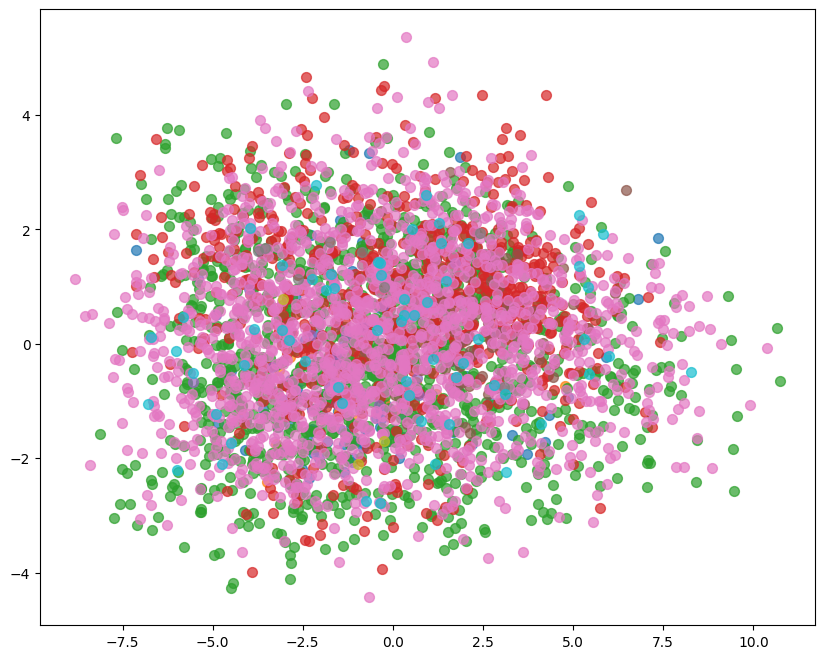

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pandas as pd
import os

# Ensure save directory
os.makedirs("projection_outputs", exist_ok=True)

# Distinct colors for each label using Plotly palettes
distinct_colors_list = (
    px.colors.qualitative.D3 +
    px.colors.qualitative.Bold +
    px.colors.qualitative.Safe +
    px.colors.qualitative.Alphabet
)
unique_labels_all = np.unique(labels)
assert len(unique_labels_all) <= len(distinct_colors_list), "Too many labels for available distinct colors."

# Map label to distinct color
distinct_color_map = {
    label: distinct_colors_list[i]
    for i, label in enumerate(unique_labels_all)
}

# Loop through 2D projections
print("Saving 2D projection images and interactive HTML...")

for name, result in projections.items():
    valid_indices = np.where(~np.isnan(result).any(axis=1) & ~np.isinf(result).any(axis=1))[0]
    result_clean = result[valid_indices]
    labels_clean = [labels[idx] for idx in valid_indices]

    # --- Matplotlib static plot ---
    plt.figure(figsize=(10, 8))
    for label in np.unique(labels_clean):
        mask = np.array(labels_clean) == label
        if np.sum(mask) > 0:
            plt.scatter(
                result_clean[mask, 0],
                result_clean[mask, 1],
                c=[distinct_color_map[label]],
                label=label,
                alpha=0.7,
                s=50
            )

    plt.title(f"2D {name} Projection")
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"projection_outputs/{name}_2d_projection.png", dpi=300)
    plt.close()

    # --- Plotly interactive plot ---
    df_plot = pd.DataFrame({
        'x': result_clean[:, 0],
        'y': result_clean[:, 1],
        'Label': labels_clean
    })

    fig = px.scatter(
        df_plot, x='x', y='y', color='Label',
        title=f"Interactive 2D {name} Projection",
        color_discrete_map=distinct_color_map,
        opacity=0.7,
        width=1000,
        height=800
    )
    fig.update_layout(
        margin=dict(l=20, r=200, t=60, b=40),
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1,
            xanchor="left",
            x=1,
            font=dict(size=12)
        )
    )
    fig.write_html(f"projection_outputs/{name}_2d_interactive.html")

print("✅ All projections saved to PNG and HTML.")


3D PCA explained variance: 0.78
Saving 3D projection images and HTMLs...


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['rgb(127, 60, 141)']

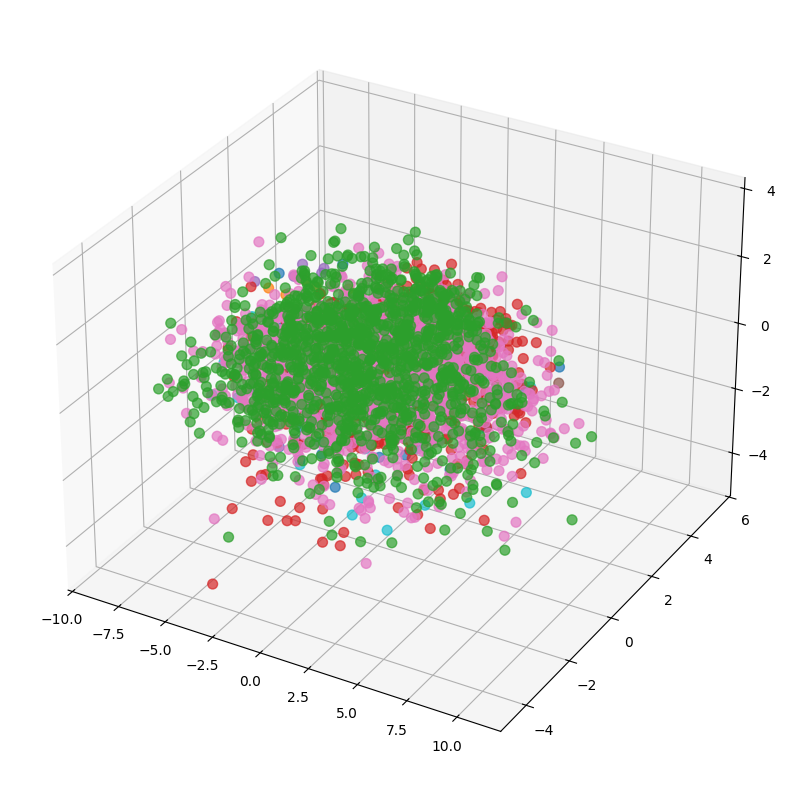

In [15]:
import os
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Ensure save directory exists
os.makedirs("projection_outputs", exist_ok=True)

# Define distinct color map
unique_labels_all = np.unique(labels)
distinct_colors_list = (
    px.colors.qualitative.D3 +
    px.colors.qualitative.Bold +
    px.colors.qualitative.Safe +
    px.colors.qualitative.Alphabet
)
assert len(unique_labels_all) <= len(distinct_colors_list), "Too many labels for available distinct colors."

distinct_color_map = {
    label: distinct_colors_list[i]
    for i, label in enumerate(unique_labels_all)
}

# --- Perform 3D Projections ---
pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(X_scaled)
print(f"3D PCA explained variance: {pca_3d.explained_variance_ratio_.sum():.2f}")

tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30)
tsne_result_3d = tsne_3d.fit_transform(X_scaled)

reducer_3d = umap.UMAP(n_components=3, random_state=42)
umap_result_3d = reducer_3d.fit_transform(X_scaled)

projections_3d = {
    'PCA': pca_result_3d,
    't-SNE': tsne_result_3d,
    'UMAP': umap_result_3d
}

print("Saving 3D projection images and HTMLs...")

for name, result in projections_3d.items():
    valid_indices = np.where(~np.isnan(result).any(axis=1) & ~np.isinf(result).any(axis=1))[0]
    result_clean = result[valid_indices]
    labels_clean = [labels[idx] for idx in valid_indices]

    # --- Matplotlib Static Plot ---
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    for label in np.unique(labels_clean):
        mask = np.array(labels_clean) == label
        if np.sum(mask) > 0:
            ax.scatter(
                result_clean[mask, 0], 
                result_clean[mask, 1], 
                result_clean[mask, 2],
                c=[distinct_color_map[label]], 
                label=label, 
                alpha=0.7, 
                s=50
            )

    ax.set_title(f"3D {name} Projection")
    ax.set_xlabel(f"{name} Component 1")
    ax.set_ylabel(f"{name} Component 2")
    ax.set_zlabel(f"{name} Component 3")
    ax.grid(True)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(f"projection_outputs/{name}_3d_projection.png", bbox_inches='tight', dpi=300)
    plt.close()

    # --- Plotly Interactive Plot ---
    df_3d = pd.DataFrame({
        'x': result_clean[:, 0],
        'y': result_clean[:, 1],
        'z': result_clean[:, 2],
        'Label': labels_clean
    })

    fig_3d = px.scatter_3d(
        df_3d,
        x='x', y='y', z='z',
        color='Label',
        color_discrete_map=distinct_color_map,
        opacity=0.7,
        title=f"Interactive 3D {name} Projection"
    )

    fig_3d.update_layout(
        margin=dict(l=20, r=20, t=60, b=40),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            font=dict(size=12)
        )
    )

    fig_3d.write_html(f"projection_outputs/{name}_3d_interactive.html")

print("✅ 3D projections saved as both PNG and HTML.")


In [9]:
def create_interactive_2d_plot(result, labels_list, name):
    df_plot = pd.DataFrame({
        'x': result[:, 0],
        'y': result[:, 1],
        'label': labels_list
    })
    
    # Using Plotly Express
    fig = px.scatter(
        df_plot, x='x', y='y', color='label',
        title=f"Interactive 2D {name} Projection",
        labels={'x': f"{name} Component 1", 'y': f"{name} Component 2"},
        opacity=0.7,
        height=800,
        width=1000
    )
    
    fig.update_layout(
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        margin=dict(l=20, r=20, b=40, t=60),
        plot_bgcolor='#F8F9FA'
    )
    
    fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')
    
    # Save as HTML
    fig.write_html(f"{name}_2d_interactive.html")

print("Creating interactive 2D visualizations...")
for name, result in projections.items():
    create_interactive_2d_plot(result, labels, name)

print("Created interactive 2D plots (HTML files)")

Creating interactive 2D visualizations...
Created interactive 2D plots (HTML files)


In [10]:
def create_interactive_3d_plot(result, labels_list, name):
    df_plot = pd.DataFrame({
        'x': result[:, 0],
        'y': result[:, 1],
        'z': result[:, 2],
        'label': labels_list
    })
    
    fig = px.scatter_3d(
        df_plot, x='x', y='y', z='z', color='label',
        title=f"Interactive 3D {name} Projection",
        labels={'x': f"{name} Component 1", 'y': f"{name} Component 2", 'z': f"{name} Component 3"},
        opacity=0.7
    )
    
    fig.update_layout(
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    
    fig.write_html(f"{name}_3d_interactive.html")

for name, result in projections_3d.items():
    create_interactive_3d_plot(result, labels, name)

print("Created interactive 3D plots (HTML files)")

Created interactive 3D plots (HTML files)


In [11]:
save_dir = "classifier_pics"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Created directory: {save_dir}")
else:
    print(f"Directory already exists: {save_dir}")

Directory already exists: classifier_pics


In [ ]:
# def create_cluster_visualization(data, cluster_labels, true_labels, projection_name, metrics):

#     is_3d = data.shape[1] == 3
#     # Create static plot
#     plt.figure(figsize=(12, 10))
    
#     if is_3d:
#         ax = plt.subplot(111, projection='3d')
#     else:
#         ax = plt.subplot(111)
    
#     unique_clusters = sorted(set(cluster_labels))
#     colors = plt.cm.tab10(np.linspace(0, 1, max(10, len(unique_clusters))))
    
#     # Plot each unique cluster
#     for i, cluster in enumerate(unique_clusters):
#         cluster_mask = cluster_labels == cluster
        
#         if is_3d:
#             ax.scatter(data[cluster_mask, 0], data[cluster_mask, 1], data[cluster_mask, 2], 
#                       c=[colors[i % 10]], label=f'Cluster {cluster}', alpha=0.7, s=40)
#         else:
#             ax.scatter(data[cluster_mask, 0], data[cluster_mask, 1], 
#                       c=[colors[i % 10]], label=f'Cluster {cluster}', alpha=0.7, s=40)
    
#     dimension = "3D" if is_3d else "2D"
#     ax.set_title(f"{dimension} {projection_name} with K-means Clustering")
#     ax.set_xlabel(f"{projection_name} Component 1")
#     ax.set_ylabel(f"{projection_name} Component 2")
#     if is_3d:
#         ax.set_zlabel(f"{projection_name} Component 3")
    
#     title_metrics = [
#         f"Silhouette: {metrics['silhouette']:.3f}",
#         f"ARI: {metrics['ari']:.3f}",
#         f"NMI: {metrics['nmi']:.3f}"
#     ]
#     plt.figtext(0.5, 0.01, ", ".join(title_metrics), ha='center', fontsize=10)
    
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
#     dim_str = "3d" if is_3d else "2d"
#     file_path = os.path.join(save_dir, f"{projection_name}_kmeans_clustering_{dim_str}.png")
#     plt.tight_layout()
#     plt.savefig(file_path, dpi=300, bbox_inches='tight')
#     plt.close()
    
#     # more plotly
#     if is_3d:
#         create_interactive_cluster_3d(data, cluster_labels, true_labels, projection_name, metrics)
#     else:
#         create_interactive_cluster_2d(data, cluster_labels, true_labels, projection_name, metrics)

In [ ]:
# def create_interactive_cluster_3d(data, cluster_labels, true_labels, projection_name, metrics):
#     df_plot = pd.DataFrame({
#         'x': data[:, 0],
#         'y': data[:, 1],
#         'z': data[:, 2],
#         'Cluster': [f'Cluster {label}' for label in cluster_labels],
#         'True Label': true_labels
#     })
    
#     title_metrics = [
#         f"Silhouette: {metrics['silhouette']:.3f}",
#         f"ARI: {metrics['ari']:.3f}",
#         f"NMI: {metrics['nmi']:.3f}"
#     ]
    
#     title = f"Interactive 3D {projection_name} with K-means Clustering<br><sub>{', '.join(title_metrics)}</sub>"
    
#     fig = px.scatter_3d(
#         df_plot, x='x', y='y', z='z', color='Cluster',
#         title=title,
#         labels={
#             'x': f"{projection_name} Component 1", 
#             'y': f"{projection_name} Component 2", 
#             'z': f"{projection_name} Component 3"
#         },
#         opacity=0.7,
#         hover_data=['True Label']
#     )
    
#     fig.update_layout(
#         legend=dict(
#             yanchor="top",
#             y=0.99,
#             xanchor="left",
#             x=0.01
#         ),
#         margin=dict(l=0, r=0, b=0, t=60)
#     )
    
#     file_path = os.path.join(save_dir, f"{projection_name}_kmeans_clustering_3d_interactive.html")
#     fig.write_html(file_path)

In [22]:
def create_interactive_cluster_2d(data, cluster_labels, true_labels, projection_name, metrics):
    distinct_colors = {
        label: color for label, color in zip(
            np.unique(true_labels), 
            px.colors.qualitative.D3 + px.colors.qualitative.Bold + px.colors.qualitative.Safe
        )
    }


    df_plot = pd.DataFrame({
        'x': data[:, 0],
        'y': data[:, 1],
        'Cluster': [f'Cluster {label}' for label in cluster_labels],
        'True Label': true_labels
    })
    
    title_metrics = [
        f"Silhouette: {metrics['silhouette']:.3f}",
        f"ARI: {metrics['ari']:.3f}",
        f"NMI: {metrics['nmi']:.3f}"
    ]
    
    title = f"Interactive 2D {projection_name} with K-means Clustering<br><sub>{', '.join(title_metrics)}</sub>"
    
    fig = px.scatter(
        df_plot, x='x', y='y', color='Cluster',
        title=title,
        labels={'x': f"{projection_name} Component 1", 'y': f"{projection_name} Component 2"},
        color_discrete_map=distinct_colors,
        hover_name='True Label',
        opacity=0.7,
        height=700,
        width=1000,
        hover_data=['True Label']
    )
    
    fig.update_layout(
        legend=dict(
            orientation="v",
            y=1,
            x=1,
            yanchor="top",
            xanchor="right",
            font=dict(size=12),
            itemwidth=40,
        ),
        margin=dict(l=40, r=40, b=60, t=100),
        plot_bgcolor='#F8F9FA'
    )
    
    fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')
    fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')
    
    file_path = os.path.join(save_dir, f"{projection_name}_kmeans_clustering_2d_interactive.html")
    fig.write_html(file_path)
    fig.show()


In [36]:
def create_interactive_cluster_3d(data, cluster_labels, true_labels, projection_name, metrics):
    distinct_colors = {
        label: color for label, color in zip(
            np.unique(true_labels), 
            px.colors.qualitative.D3 + px.colors.qualitative.Bold + px.colors.qualitative.Safe
        )
    }

    df_plot = pd.DataFrame({
        'x': data[:, 0],
        'y': data[:, 1],
        'z': data[:, 2],
        'Cluster': [f'Cluster {label}' for label in cluster_labels],
        'True Label': true_labels
    })
    
    title_metrics = [
        f"Silhouette: {metrics['silhouette']:.3f}",
        f"ARI: {metrics['ari']:.3f}",
        f"NMI: {metrics['nmi']:.3f}"
    ]
    
    title = f"Interactive 3D {projection_name} with K-means Clustering<br><sub>{', '.join(title_metrics)}</sub>"
    
    fig = px.scatter_3d(
        df_plot, x='x', y='y', z='z', color='Cluster',
        title=title,
        labels={
            'x': f"{projection_name} Component 1", 
            'y': f"{projection_name} Component 2", 
            'z': f"{projection_name} Component 3"
        },
        opacity=0.7,
        hover_data=['True Label'], 
        color_discrete_map=distinct_colors,
        hover_name='True Label',
    )
    
    fig.update_layout(
        legend=dict(
            orientation="v",
            y=1,
            x=1,
            yanchor="top",
            xanchor="right",
            font=dict(size=12),
            itemwidth=40,
        ),
        margin=dict(l=20, r=220, b=60, t=20),
        plot_bgcolor='#F8F9FA'
    )
    
    file_path = os.path.join(save_dir, f"{projection_name}_kmeans_clustering_3d_interactive.html")
    fig.write_html(file_path)
    fig.show()

In [37]:
def apply_kmeans_clustering(projection_data, true_labels, projection_name, n_clusters):

    print(f"Applying K-means clustering on {projection_name} projection...")
    
    # Create and fit K-means model
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(projection_data)
    
    silhouette = silhouette_score(projection_data, cluster_labels)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    
    print(f"  Silhouette Score: {silhouette:.4f}")
    print(f"  ARI (vs true labels): {ari:.4f}")
    print(f"  NMI (vs true labels): {nmi:.4f}")
    
    results = {
        'labels': cluster_labels,
        'silhouette': silhouette,
        'ari': ari,
        'nmi': nmi
    }
    
    # create_interactive_cluster_2d(projection_data, cluster_labels, true_labels, projection_name, results)
    create_interactive_cluster_3d(projection_data, cluster_labels, true_labels, projection_name, results)
    
    return results

In [38]:
save_dir = "projection_outputs"

unique_labels = np.unique(labels)
n_clusters = len(unique_labels)

print(f"Applying K-means clustering with {n_clusters} clusters...")

# For 2D
# clustering_results_2d = {}
# for name, projection in projections.items():
#     print(f"\nClustering on 2D {name} projection:")
#     clustering_results_2d[name] = apply_kmeans_clustering(projection, labels, name, n_clusters)

# For 3D
clustering_results_3d = {}
for name, projection in projections_3d.items():
    print(f"\nClustering on 3D {name} projection:")
    clustering_results_3d[name] = apply_kmeans_clustering(projection, labels, name, n_clusters)

Applying K-means clustering with 22 clusters...

Clustering on 3D PCA projection:
Applying K-means clustering on PCA projection...
  Silhouette Score: 0.2313
  ARI (vs true labels): 0.0087
  NMI (vs true labels): 0.0558



Clustering on 3D t-SNE projection:
Applying K-means clustering on t-SNE projection...
  Silhouette Score: 0.2832
  ARI (vs true labels): 0.0113
  NMI (vs true labels): 0.0598



Clustering on 3D UMAP projection:
Applying K-means clustering on UMAP projection...
  Silhouette Score: 0.3146
  ARI (vs true labels): 0.0120
  NMI (vs true labels): 0.0588


In [17]:
# Summary table of results
def create_clustering_summary(results_2d, results_3d):
    summary_data = []
    
    for proj_name, metrics in results_2d.items():
        row = {
            'Projection': proj_name,
            'Dimensions': '2D',
            'Silhouette': metrics['silhouette'],
            'ARI': metrics['ari'],
            'NMI': metrics['nmi']
        }
        summary_data.append(row)
    
    for proj_name, metrics in results_3d.items():
        row = {
            'Projection': proj_name,
            'Dimensions': '3D',
            'Silhouette': metrics['silhouette'],
            'ARI': metrics['ari'],
            'NMI': metrics['nmi']
        }
        summary_data.append(row)
    
    # CSort df by ARI (higher is better)
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values(by=['ARI', 'NMI'], ascending=False)
    
    csv_path = os.path.join(save_dir, "kmeans_clustering_results_summary.csv")
    summary_df.to_csv(csv_path, index=False)
    print(f"\nSummary saved to {csv_path}")
    
    # Bar chart
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=summary_df.melt(id_vars=['Projection', 'Dimensions'], 
                            value_vars=['Silhouette', 'ARI', 'NMI']),
        x='Projection', y='value', hue='variable',
        palette='viridis'
    )
    plt.title('K-means Clustering Performance across Projections')
    plt.xlabel('Projection Method')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "kmeans_performance_comparison.png"), dpi=300)
    plt.close()
    
    return summary_df

In [18]:
summary_df = create_clustering_summary(clustering_results_2d, clustering_results_3d)

best_method = summary_df.iloc[0]
print("\n" + "="*50)
print("Best K-means Clustering Method:")
print(f"Projection: {best_method['Projection']} {best_method['Dimensions']}")
print(f"ARI: {best_method['ARI']:.4f}")
print(f"NMI: {best_method['NMI']:.4f}")
print(f"Silhouette Score: {best_method['Silhouette']:.4f}")
print("="*50)


Summary saved to classifier_pics\kmeans_clustering_results_summary.csv

Best K-means Clustering Method:
Projection: UMAP 2D
ARI: 0.0315
NMI: 0.1748
Silhouette Score: 0.3777


In [19]:
def evaluate_feature_importance(X_combined, labels, feature_names):

    print("Now: evaluating individual feature performance with SVM.")
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(labels)
    feature_performances = {}
    kernels = ['linear', 'rbf', 'sigmoid']
    
    # Test each feature individually
    for i in range(X_combined.shape[1]):
        feature_data = X_combined[:, i].reshape(-1, 1)  # Extract single feature as column vector
        feature_name = feature_names[i] if i < len(feature_names) else f"Feature_{i}"
        
        print(f"\nTesting feature: {feature_name}")
        
        scaler = StandardScaler()
        feature_scaled = scaler.fit_transform(feature_data)
        
        X_train, X_test, y_train, y_test = train_test_split(
            feature_scaled, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
        )
        
        best_kernel = None
        best_accuracy = 0
        best_model = None
        best_predictions = None
        
        for kernel in kernels:
            # Grid search for RBF kernel
            if kernel == 'rbf':
                param_grid = {
                    'C': [0.1, 1, 10, 100],
                    'gamma': ['scale', 'auto', 0.1, 0.01]
                }
                svm = GridSearchCV(
                    SVC(kernel=kernel, random_state=42),
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=3,
                    n_jobs=-1
                )
                svm.fit(X_train, y_train)
                model = svm.best_estimator_
            else:
                model = SVC(kernel=kernel, random_state=42)
                model.fit(X_train, y_train)
            
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            
            print(f"  {kernel.upper()} kernel accuracy: {accuracy:.4f}")
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_kernel = kernel
                best_model = model
                best_predictions = y_pred
        
        feature_performances[feature_name] = {
            'best_kernel': best_kernel,
            'best_accuracy': best_accuracy,
            'confusion_matrix': confusion_matrix(y_test, best_predictions),
            'classification_report': classification_report(y_test, best_predictions, 
                                                         target_names=le.classes_, 
                                                         output_dict=True),
            'model': best_model
        }
        
        print(f"  Best kernel for {feature_name}: {best_kernel.upper()} with accuracy {best_accuracy:.4f}")
    
    best_feature = max(feature_performances.items(), 
                      key=lambda x: x[1]['best_accuracy'])
    
    print("\n" + "="*60)
    print(f"Best single feature: {best_feature[0]} with {best_feature[1]['best_kernel']} kernel")
    print(f"Accuracy: {best_feature[1]['best_accuracy']:.4f}")
    print("="*60)
    
    plot_feature_performance(feature_performances, le.classes_)
    
    return feature_performances

In [20]:
def plot_feature_performance(feature_performances, class_names):

    features = list(feature_performances.keys())
    accuracies = [data['best_accuracy'] for data in feature_performances.values()]
    kernels = [data['best_kernel'] for data in feature_performances.values()]
    
    plot_data = pd.DataFrame({
        'Feature': features,
        'Accuracy': accuracies,
        'Kernel': kernels
    })
    
    plot_data = plot_data.sort_values('Accuracy', ascending=False)
    
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x='Accuracy', y='Feature', hue='Kernel', data=plot_data)
    plt.title('SVM Classification Accuracy by Individual Feature', fontsize=15)
    plt.xlabel('Accuracy', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('feature_importance_svm.png', dpi=300)
    plt.close()
    
    best_feature = plot_data.iloc[0]['Feature']
    best_perf = feature_performances[best_feature]
    
    # Confusion matrix for the best feature
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        best_perf['confusion_matrix'], 
        annot=True if len(class_names) <= 10 else False, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names, 
        yticklabels=class_names
    )
    plt.title(f'Confusion Matrix for Best Feature: {best_feature}\nKernel: {best_perf["best_kernel"]}', fontsize=13)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'best_feature_confusion_matrix.png', dpi=300)
    plt.close()

    # F1 scores for the best feature
    class_f1 = {
        class_name: report['f1-score'] 
        for class_name, report in best_perf['classification_report'].items() 
        if class_name not in ['accuracy', 'macro avg', 'weighted avg']
    }
    
    plt.figure(figsize=(12, 6))
    pd.Series(class_f1).sort_values().plot(kind='barh', color='teal')
    plt.title(f'F1-Scores by Class for Best Feature ({best_feature})', fontsize=13)
    plt.xlabel('F1-Score')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'best_feature_f1_scores.png', dpi=300)
    plt.close()

In [21]:
mfcc_names = [f"MFCC_{i+1}" for i in range(13)]
audio_stat_names = ["Mean", "StdDev", "Max", "Min", "RMS", "ZCR"]
feature_names = mfcc_names + audio_stat_names

print("Testing SVM on individual features...")
feature_performances = evaluate_feature_importance(X_scaled, labels, feature_names)

# Details about the best features
top_features = sorted(
    [(name, data['best_kernel'], data['best_accuracy']) 
     for name, data in feature_performances.items()],
    key=lambda x: x[2],
    reverse=True
)[:5]  # Top 5 features

print("\nTop 5 Individual Features:")
for i, (feature, kernel, accuracy) in enumerate(top_features):
    print(f"{i+1}. {feature} with {kernel} kernel: {accuracy:.4f}")

Testing SVM on individual features...
Now: evaluating individual feature performance with SVM.

Testing feature: MFCC_1
  LINEAR kernel accuracy: 0.2325
  RBF kernel accuracy: 0.2493
  SIGMOID kernel accuracy: 0.1831
  Best kernel for MFCC_1: RBF with accuracy 0.2493

Testing feature: MFCC_2
  LINEAR kernel accuracy: 0.2502
  RBF kernel accuracy: 0.2537
  SIGMOID kernel accuracy: 0.1989
  Best kernel for MFCC_2: RBF with accuracy 0.2537

Testing feature: MFCC_3
  LINEAR kernel accuracy: 0.2517
  RBF kernel accuracy: 0.2547
  SIGMOID kernel accuracy: 0.1747
  Best kernel for MFCC_3: RBF with accuracy 0.2547

Testing feature: MFCC_4
  LINEAR kernel accuracy: 0.2562
  RBF kernel accuracy: 0.2552
  SIGMOID kernel accuracy: 0.1520
  Best kernel for MFCC_4: LINEAR with accuracy 0.2562

Testing feature: MFCC_5
  LINEAR kernel accuracy: 0.2577
  RBF kernel accuracy: 0.2547
  SIGMOID kernel accuracy: 0.1787
  Best kernel for MFCC_5: LINEAR with accuracy 0.2577

Testing feature: MFCC_6
  LINEAR 

In [22]:
def create_hierarchical_ensemble(X_scaled, labels):

    print("\nNext: hierarchical trickle-down ensemble classification.")
    
    labels_array = np.array(labels)
    
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels_array)
    
    unique_labels = np.unique(labels_array)
    label_counts = {label: np.sum(labels_array == label) for label in unique_labels}
    
    # Sort labels by frequency (most common first)
    ordered_labels = sorted(label_counts.keys(), key=lambda x: label_counts[x], reverse=True)
    print(f"Label hierarchy will be: {ordered_labels}")
    
    kernel = 'rbf'
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, labels_array, test_size=0.25, random_state=42, stratify=labels_array
    )
    
    binary_classifiers = {}
    remaining_labels = ordered_labels.copy()
    
    # For each level (except the last one which doesn't need a classifier)
    for i in range(len(ordered_labels) - 1):
        current_label = remaining_labels[0]
        remaining_labels = remaining_labels[1:]
        
        train_indices = [idx for idx, label in enumerate(y_train) if label == current_label or label in remaining_labels]
        binary_X = X_train[train_indices]
        binary_y = np.array([1 if y_train[idx] == current_label else 0 for idx in train_indices])
        
        print(f"Training binary classifier for: '{current_label}' vs rest")
        classifier = SVC(kernel=kernel, probability=True, random_state=42)
        classifier.fit(binary_X, binary_y)
        
        binary_classifiers[current_label] = classifier
    
    # Trickle-down prediction
    def predict_trickle_down(X):
        predictions = []
        
        for sample in X:
            remaining = ordered_labels.copy()
            sample_reshaped = sample.reshape(1, -1)
            predicted = False
            
            # Trickle down through the binary classifiers
            for level, label in enumerate(ordered_labels[:-1]):
                classifier = binary_classifiers[label]
                if classifier.predict(sample_reshaped)[0] == 1:
                    predictions.append(label)
                    predicted = True
                    break
            
            if not predicted:
                predictions.append(ordered_labels[-1])
        
        return np.array(predictions)
    
    print("\nEvaluating trickle-down ensemble...")
    y_pred = predict_trickle_down(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Ensemble accuracy: {accuracy:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    report_text = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report_text)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
    plt.title("Confusion Matrix - Hierarchical Ensemble Classification")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.savefig("ensemble_confusion_matrix.png", dpi=300)
    plt.close()
    
    precision = {}
    recall = {}
    f1 = {}
    
    for label in unique_labels:
        # Get class metrics from the classification report dict
        if label in report_dict:
            precision[label] = report_dict[label]['precision']
            recall[label] = report_dict[label]['recall']
            f1[label] = report_dict[label]['f1-score']
    
    plt.figure(figsize=(12, 6))
    f1_series = pd.Series(f1)
    f1_series.sort_values().plot(kind='barh', color='teal')
    plt.title("F1-Scores by Class - Hierarchical Ensemble")
    plt.xlabel("F1-Score")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("ensemble_f1_scores.png", dpi=300)
    plt.close()
    
    return {
        'classifiers': binary_classifiers,
        'accuracy': accuracy, 
        'label_hierarchy': ordered_labels,
        'confusion_matrix': cm,
        'classification_report': report_dict,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [23]:
ensemble_results = create_hierarchical_ensemble(X_scaled, labels)

print(f"\nTrickle-down hierarchy: {' → '.join(ensemble_results['label_hierarchy'])}")
print(f"Final ensemble accuracy: {ensemble_results['accuracy']:.4f}")

print("\n=== Performance Metrics Summary ===")
print(f"Macro Avg Precision: {ensemble_results['classification_report']['macro avg']['precision']:.4f}")
print(f"Macro Avg Recall: {ensemble_results['classification_report']['macro avg']['recall']:.4f}")  
print(f"Macro Avg F1-Score: {ensemble_results['classification_report']['macro avg']['f1-score']:.4f}")
print(f"Weighted Avg F1-Score: {ensemble_results['classification_report']['weighted avg']['f1-score']:.4f}")


Next: hierarchical trickle-down ensemble classification.
Label hierarchy will be: [np.str_('selftalk'), np.str_('frustrated'), np.str_('delighted'), np.str_('dysregulated'), np.str_('social'), np.str_('request'), np.str_('affectionate'), np.str_('yes'), np.str_('bathroom'), np.str_('dysregulation-bathroom'), np.str_('dysregulation-sick'), np.str_('glee'), np.str_('greeting'), np.str_('happy'), np.str_('help'), np.str_('hunger'), np.str_('laugh'), np.str_('laughter'), np.str_('more'), np.str_('no'), np.str_('protest'), np.str_('tablet')]
Training binary classifier for: 'selftalk' vs rest
Training binary classifier for: 'frustrated' vs rest
Training binary classifier for: 'delighted' vs rest
Training binary classifier for: 'dysregulated' vs rest
Training binary classifier for: 'social' vs rest
Training binary classifier for: 'request' vs rest
Training binary classifier for: 'affectionate' vs rest
Training binary classifier for: 'yes' vs rest
Training binary classifier for: 'bathroom' vs

In [24]:
def analyze_performance_metrics(model_name, confusion_mat, class_report, labels):

    # Normalize confusion matrix (true labels)
    cm_normalized = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Normalized Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{model_name.lower().replace(' ', '_')}_norm_confusion_matrix.png", dpi=300)
    plt.close()
    
    precision = []
    recall = []
    f1 = []
    support = []
    
    for label in labels:
        if label in class_report:
            precision.append(class_report[label]['precision'])
            recall.append(class_report[label]['recall'])
            f1.append(class_report[label]['f1-score'])
            support.append(class_report[label]['support'])
    
    metrics_df = pd.DataFrame({
        'Class': labels,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Support': support
    })
    
    plt.figure(figsize=(14, 12))
    
    metrics_df_sorted = metrics_df.sort_values('F1 Score')
    
    metrics_plot = metrics_df_sorted.melt(
        id_vars=['Class', 'Support'],
        value_vars=['Precision', 'Recall', 'F1 Score'],
        var_name='Metric', value_name='Value'
    )
    
    g = sns.barplot(x='Value', y='Class', hue='Metric', data=metrics_plot, palette=['#5DADE2', '#58D68D', '#F4D03F'])
    
    # Support count annotations
    for i, (_, row) in enumerate(metrics_df_sorted.iterrows()):
        plt.text(0.02, i, f"n={int(row['Support'])}", va='center', color='black', fontsize=8)
    
    plt.title(f"Classification Metrics by Class - {model_name}", fontsize=16)
    plt.xlabel('Score', fontsize=12)
    plt.ylabel('Class', fontsize=12)
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.savefig(f"{model_name.lower().replace(' ', '_')}_metrics_by_class.png", dpi=300)
    plt.close()
    
    error_counts = {}
    for i in range(len(labels)):
        for j in range(len(labels)):
            if i != j and confusion_mat[i, j] > 0:
                error_type = f"{labels[i]} → {labels[j]}"
                error_counts[error_type] = confusion_mat[i, j]
    
    if error_counts:
        # Sort by count and get top errors
        error_df = pd.DataFrame(list(error_counts.items()), columns=['Error Type', 'Count'])
        error_df = error_df.sort_values('Count', ascending=False).head(15)  # Top 15 errors
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Count', y='Error Type', data=error_df, palette='Reds_r')
        plt.title(f"Top Misclassifications - {model_name}", fontsize=16)
        plt.xlabel('Count', fontsize=12)
        plt.ylabel('Error Type (True → Predicted)', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"{model_name.lower().replace(' ', '_')}_top_errors.png", dpi=300)
        plt.close()

    return metrics_df

In [25]:
unique_labels = np.unique(labels)
ensemble_metrics = analyze_performance_metrics(
    "Hierarchical Ensemble",
    ensemble_results['confusion_matrix'],
    ensemble_results['classification_report'],
    unique_labels
)

best_feature_name = sorted([(name, data['best_accuracy']) for name, data in feature_performances.items()],
                         key=lambda x: x[1], reverse=True)[0][0]

# Fix for TypeError
best_feature_metrics = analyze_performance_metrics(
    f"SVM with {best_feature_name}",
    feature_performances[best_feature_name]['confusion_matrix'],
    feature_performances[best_feature_name]['classification_report'],
    sorted(list(feature_performances[best_feature_name]['classification_report'].keys() - 
               {'accuracy', 'macro avg', 'weighted avg'}))
)

print("\n==== Model Performance Comparison ====")
print(f"Hierarchical Ensemble Accuracy: {ensemble_results['accuracy']:.4f}")
print(f"Best Single Feature ({best_feature_name}) Accuracy: {feature_performances[best_feature_name]['best_accuracy']:.4f}")
print("\nMacro F1-Scores:")
print(f"Hierarchical Ensemble: {ensemble_results['classification_report']['macro avg']['f1-score']:.4f}")
print(f"Best Single Feature: {feature_performances[best_feature_name]['classification_report']['macro avg']['f1-score']:.4f}")


==== Model Performance Comparison ====
Hierarchical Ensemble Accuracy: 0.1732
Best Single Feature (MFCC_9) Accuracy: 0.2641

Macro F1-Scores:
Hierarchical Ensemble: 0.2614
Best Single Feature: 0.0326
